In [2]:
#### detect hardware
from google.colab import drive
drive.mount('/content/drive/')

#### check for gpu
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print(local_device_protos)

get_available_gpus()
##################################

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7451484936110059826
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5103282946345873593
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15430072261708651376
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11146783616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10821474296948960059
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
root = '/content/drive/My Drive/DNAChallenge/'
trainFeatures = root + 'train_values.csv'
trainLabels = root + 'train_labels.csv'
testFeatures =  root + 'test_values.csv'
submission = root + 'submission.csv'
emb = root + 'm_char.model'

In [5]:
x_train = pd.read_csv(trainFeatures)
y_train = pd.read_csv(trainLabels)

x_test = pd.read_csv(testFeatures)

In [ ]:
x_train = x_train.set_index('sequence_id').join(y_train.set_index('sequence_id'))

In [ ]:
metaDataCols = [x for x in x_train.columns if '_' in x]
print(metaDataCols)
print(len(metaDataCols))

['bacterial_resistance_ampicillin', 'bacterial_resistance_chloramphenicol', 'bacterial_resistance_kanamycin', 'bacterial_resistance_other', 'bacterial_resistance_spectinomycin', 'copy_number_high_copy', 'copy_number_low_copy', 'copy_number_unknown', 'growth_strain_ccdb_survival', 'growth_strain_dh10b', 'growth_strain_dh5alpha', 'growth_strain_neb_stable', 'growth_strain_other', 'growth_strain_stbl3', 'growth_strain_top10', 'growth_strain_xl1_blue', 'growth_temp_30', 'growth_temp_37', 'growth_temp_other', 'selectable_markers_blasticidin', 'selectable_markers_his3', 'selectable_markers_hygromycin', 'selectable_markers_leu2', 'selectable_markers_neomycin', 'selectable_markers_other', 'selectable_markers_puromycin', 'selectable_markers_trp1', 'selectable_markers_ura3', 'selectable_markers_zeocin', 'species_budding_yeast', 'species_fly', 'species_human', 'species_mouse', 'species_mustard_weed', 'species_nematode', 'species_other', 'species_rat', 'species_synthetic', 'species_zebrafish']
39


In [ ]:
metaData = x_train[metaDataCols].values
print(metaData)
print(metaData.shape)

[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(63017, 39)


In [ ]:
!pip install sentencepiece

In [ ]:
import sentencepiece as spm

In [ ]:
sp_char = spm.SentencePieceProcessor()
sp_char.load(emb)

True

In [ ]:
#ATCG
#1234
def fct(char):
  if char == 'A':
    return 1
  if char == 'T':
    return 2
  if char == 'C':
    return 3
  if char == 'G':
    return 4
  if char == 'N':
    return 5

MAXLEN = 10000

val = []

for id, row in x_train.iterrows():
  res = sp_char.encode_as_ids(row['sequence'])
  #res = list(map(fct, list(row['sequence'])))
  res = res[0:MAXLEN]

  if len(res) < MAXLEN:
    res += [0] * (MAXLEN-len(res))

  val.append(np.array(res).astype(np.uint8))

In [ ]:
val = np.array(val)
print(val.shape)

(63017, 10000)


In [ ]:
target = [x for x in y_train.columns if 'sequence' not in x]

In [ ]:
x_train, x_val, metaData_train, metaData_val, y_train, y_val = train_test_split(val, metaData, x_train[target], test_size=0.2, random_state=44)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(metaData_train.shape)
print(metaData_val.shape)
print(y_train.shape)
print(y_val.shape)

(50413, 10000)
(12604, 10000)
(50413, 39)
(12604, 39)
(50413, 1314)
(12604, 1314)


In [ ]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy) 

######################## try mixed policy T4
EMBSIZE = 128

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
!pip install keras-tcn
!pip install sentencepiece

In [ ]:
from sklearn.utils import class_weight
y_integers = np.argmax(y_train.values, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

y_integers_val = np.argmax(y_val.values, axis=1)

d_class_weights[1313] = 0.0

In [ ]:
print(d_class_weights)

{0: 2.7425198563812425, 1: 1.2385573544947548, 2: 3.1996064991114497, 3: 19.197638994668697, 4: 0.13761748383275052, 5: 2.55968519928916, 6: 2.2585457640786704, 7: 2.7425198563812425, 8: 0.08221686935618286, 9: 5.485039712762485, 10: 0.6856299640953106, 11: 2.7425198563812425, 12: 0.07070953589196574, 13: 4.799409748667174, 14: 9.598819497334349, 15: 2.9534829222567227, 16: 1.0377102159280378, 17: 1.2385573544947548, 18: 0.4682350974309438, 19: 7.679055597867479, 20: 1.6693599125798868, 21: 3.8395277989337395, 22: 6.399212998222899, 23: 2.7425198563812425, 24: 2.2585457640786704, 25: 1.0665354997038166, 26: 2.55968519928916, 27: 2.9534829222567227, 28: 0.7835771018232122, 29: 1.7452399086062453, 30: 0.06585810975872623, 31: 6.399212998222899, 32: 4.266141998815266, 33: 7.679055597867479, 34: 2.7425198563812425, 35: 7.679055597867479, 36: 5.485039712762485, 37: 3.8395277989337395, 38: 6.399212998222899, 39: 1.422047332938422, 40: 3.8395277989337395, 41: 7.679055597867479, 42: 1.47674146

In [ ]:
metaInputs = tf.keras.layers.Input(shape=(39,))

m = tf.keras.layers.Dense(256, activation='relu')(metaInputs)
m = tf.keras.layers.Dense(256, activation='relu')(m)


In [ ]:
inputs =  tf.keras.layers.Input(shape=(MAXLEN,1))

c = tf.keras.layers.Conv1D(8, 5, padding='same', activation='relu')(inputs)
c = tf.keras.layers.MaxPooling1D(3)(c)

d = tf.keras.layers.Conv1D(8, 7, padding='same', activation='relu')(inputs)
d = tf.keras.layers.MaxPooling1D(3)(d)

e = tf.keras.layers.Conv1D(8, 11, padding='same', activation='relu')(inputs)
e = tf.keras.layers.MaxPooling1D(3)(e)

x = tf.keras.layers.concatenate([c,d,e])
x = tf.keras.layers.Conv1D(8, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(8, 5, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Flatten()(x)
###Dense layers
x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = tf.keras.layers.concatenate([x,m])
x = tf.keras.layers.Dense(128, activation='relu')(x)

### prediction layer
predictions = tf.keras.layers.Dense(1314, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=predictions)

In [ ]:
metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10)

'''
class MyCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
      if logs['val_top_k_categorical_accuracy'] > 0.9:
       model.stop_training = True

es = MyCallBack()
'''

"\nclass MyCallBack(tf.keras.callbacks.Callback):\n  def on_epoch_end(self, epoch, logs=None):\n      if logs['val_top_k_categorical_accuracy'] > 0.9:\n       model.stop_training = True\n\nes = MyCallBack()\n"

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['sparse_categorical_accuracy', metric])

In [ ]:
model.summary()

Model: "functional_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 10000, 8)     48          input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 10000, 8)     64          input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 10000, 8)     96          input_4[0][0]                    
_______________________________________________________________________________________

In [ ]:
!pip install keras-lr-finder

In [ ]:
from keras_lr_finder import LRFinder

lr_finder = LRFinder(model)

lr_finder.find(x_train, y_train, start_lr=0.00001, end_lr=1, batch_size=256, epochs=5)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)


In [ ]:
print(x_train.shape)
print(x_val.shape)

print(metaData_train.shape)
print(metaData_val.shape)

print(y_integers.shape)
print(y_integers_val.shape)

(50413, 10000)
(12604, 10000)
(50413, 39)
(12604, 39)
(50413,)
(12604,)


In [ ]:
history = model.fit(x_train, y_integers, epochs=100,  batch_size=2048, validation_data=(x_val, y_integers_val), class_weight=d_class_weights)

Epoch 1/100
25/25 [==============================] - 7s 281ms/step - loss: 20.8400 - sparse_categorical_accuracy: 0.1069 - sparse_top_k_categorical_accuracy: 0.3116 - val_loss: 5.4963 - val_sparse_categorical_accuracy: 0.1738 - val_sparse_top_k_categorical_accuracy: 0.3610
Epoch 2/100
25/25 [==============================] - 7s 274ms/step - loss: 16.5096 - sparse_categorical_accuracy: 0.1879 - sparse_top_k_categorical_accuracy: 0.3849 - val_loss: 5.1635 - val_sparse_categorical_accuracy: 0.2045 - val_sparse_top_k_categorical_accuracy: 0.4014
Epoch 3/100
25/25 [==============================] - 7s 279ms/step - loss: 15.0637 - sparse_categorical_accuracy: 0.2257 - sparse_top_k_categorical_accuracy: 0.4201 - val_loss: 4.9129 - val_sparse_categorical_accuracy: 0.2321 - val_sparse_top_k_categorical_accuracy: 0.4317
Epoch 4/100
25/25 [==============================] - 7s 282ms/step - loss: 13.8910 - sparse_categorical_accuracy: 0.2515 - sparse_top_k_categorical_accuracy: 0.4572 - val_loss: 4

In [ ]:
#### helper plot function
import matplotlib.pyplot as plt
def plot_acc_loss(history):
  plt.plot(history.history['sparse_categorical_accuracy'], label='acc')
  plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_acc')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(loc='upper left')
  plt.show()


  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_los')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()
    
  plt.plot(history.history['top_k_sparse_categorical_accuracy'], label='top10')
  plt.plot(history.history['val_top_k_sparse_categorical_accuracy'], label='val_top10')
  plt.title('model top10')
  plt.ylabel('top10')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

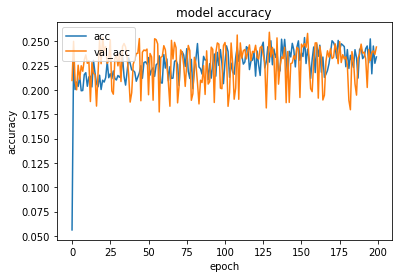

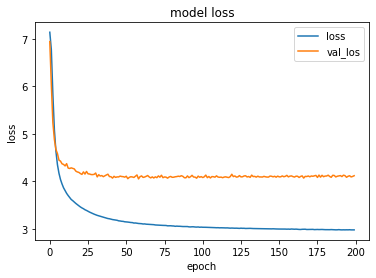

KeyError: ignored

In [ ]:
plot_acc_loss(history)

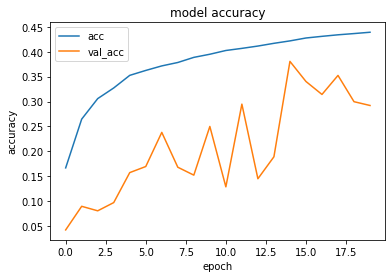

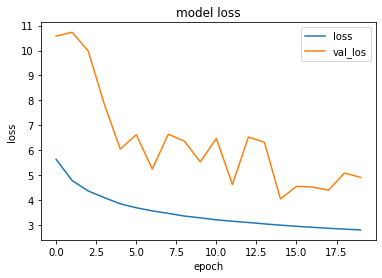

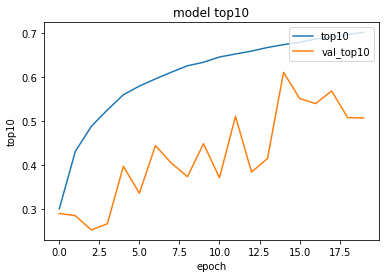

In [ ]:
plot_acc_loss(history)